## Time Series Forecasting Using XGBoost - Advanced Methods

Lets import the desired libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

### Outline - Things to be Covered
- Outlier analysis
- Forecasting horizon Explained
- Time Series Cross Validation Explained
- Lag Features
- Predicting the Energy Consumption

### Data Reading

In [2]:
df = pd.read_csv('./data/PJME_hourly.csv')
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


### Data Visualization

In [3]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

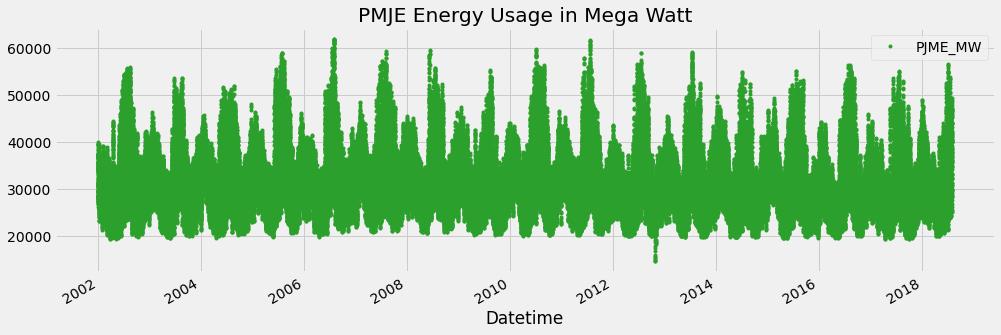

In [4]:
df.plot(style='.', figsize=(15, 5), 
       color=color_pal[2],
       title = 'PMJE Energy Usage in Mega Watt')
plt.show()

If wee see the graph, we can see that there are values in between 2012 and 2014 which are below than 20000. These seems to be outliers

Lets Visualize the one week data for better understanding.

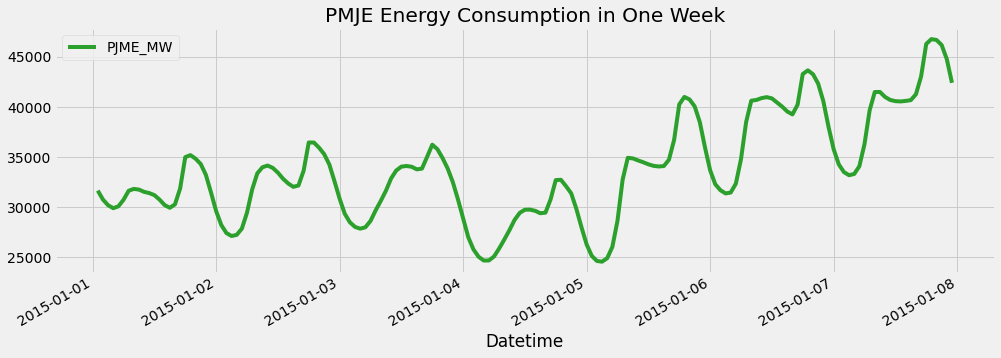

In [5]:
ax = df[(df.index > '01-01-2015') & (df.index < '-01-08-2015')].plot(style='-', figsize=(15, 5),
                                                                    color=color_pal[2])
ax.set_title("PMJE Energy Consumption in One Week")
plt.show()

### Outlier analysis and Removal

Lets plot a histogram

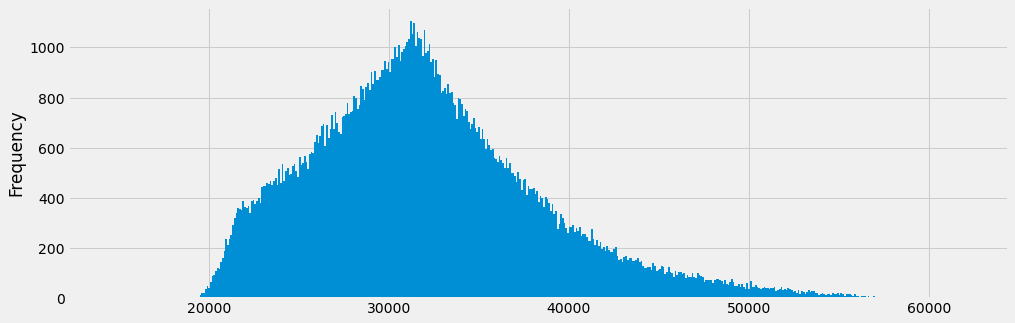

In [6]:
df['PJME_MW'].plot(kind='hist', bins=500, figsize=(15, 5))
plt.show()

We can see there are values below than 20000. Lets get these values and plot them

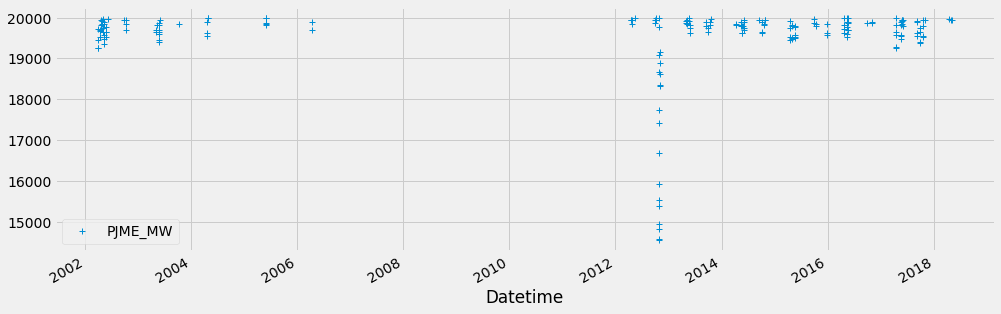

In [7]:
df.query('PJME_MW < 20000').plot(style='+', figsize=(15, 5))
plt.show()

We can see that there exist values below 20000, which seems to be normal. However, there are values which goes till 150000. Those seems to be outlier. Lets get those values and plot them

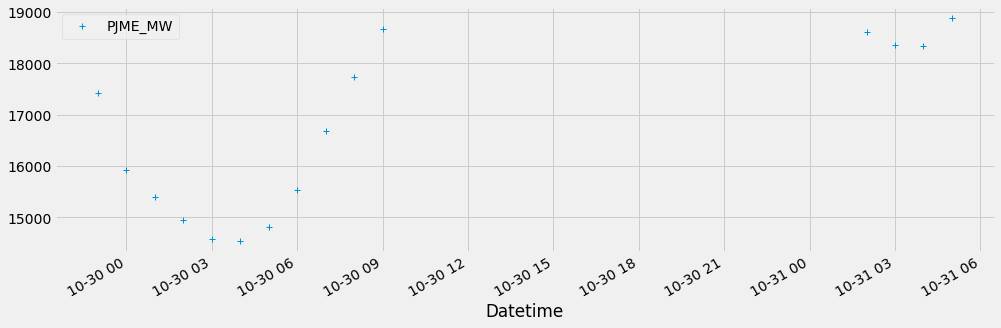

In [8]:
df.query('PJME_MW < 19000').plot(style='+', figsize=(15, 5))
plt.show()

To Remove these values, all we have to do is to just copy the values greater the 19000 and discard the lowers ones.

In [9]:
df = df.query('PJME_MW > 19000').copy()

### Train/Test Split

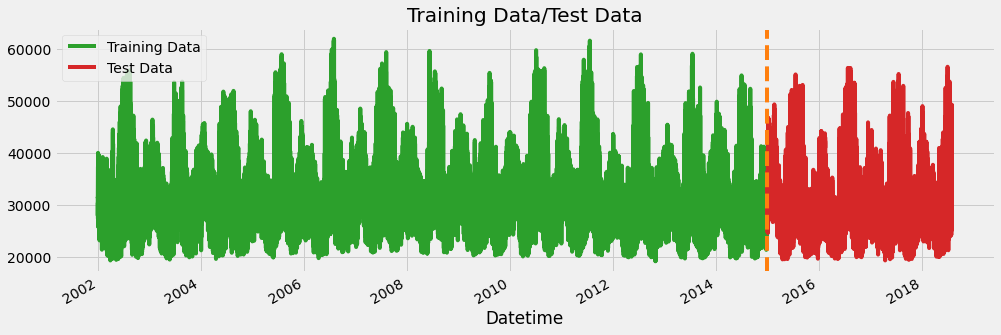

In [10]:
train = df[df.index < '01-01-2015']
test = df[df.index >= '01-01-2015']

# lets plot the data
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Train Data', title='Training Data/Test Data', color=color_pal[2])
test.plot(ax=ax, label='Test Data', color = color_pal[3])
ax.axvline('01-01-2015', color=color_pal[1], ls='--')
ax.legend(['Training Data', 'Test Data'])
plt.show()

A better way to to do this will be using cross validation

### Time Series Cross Validation

In [11]:
df = df.sort_index()
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)


Time Series Object is just a generator, lets use it to generate the data. 

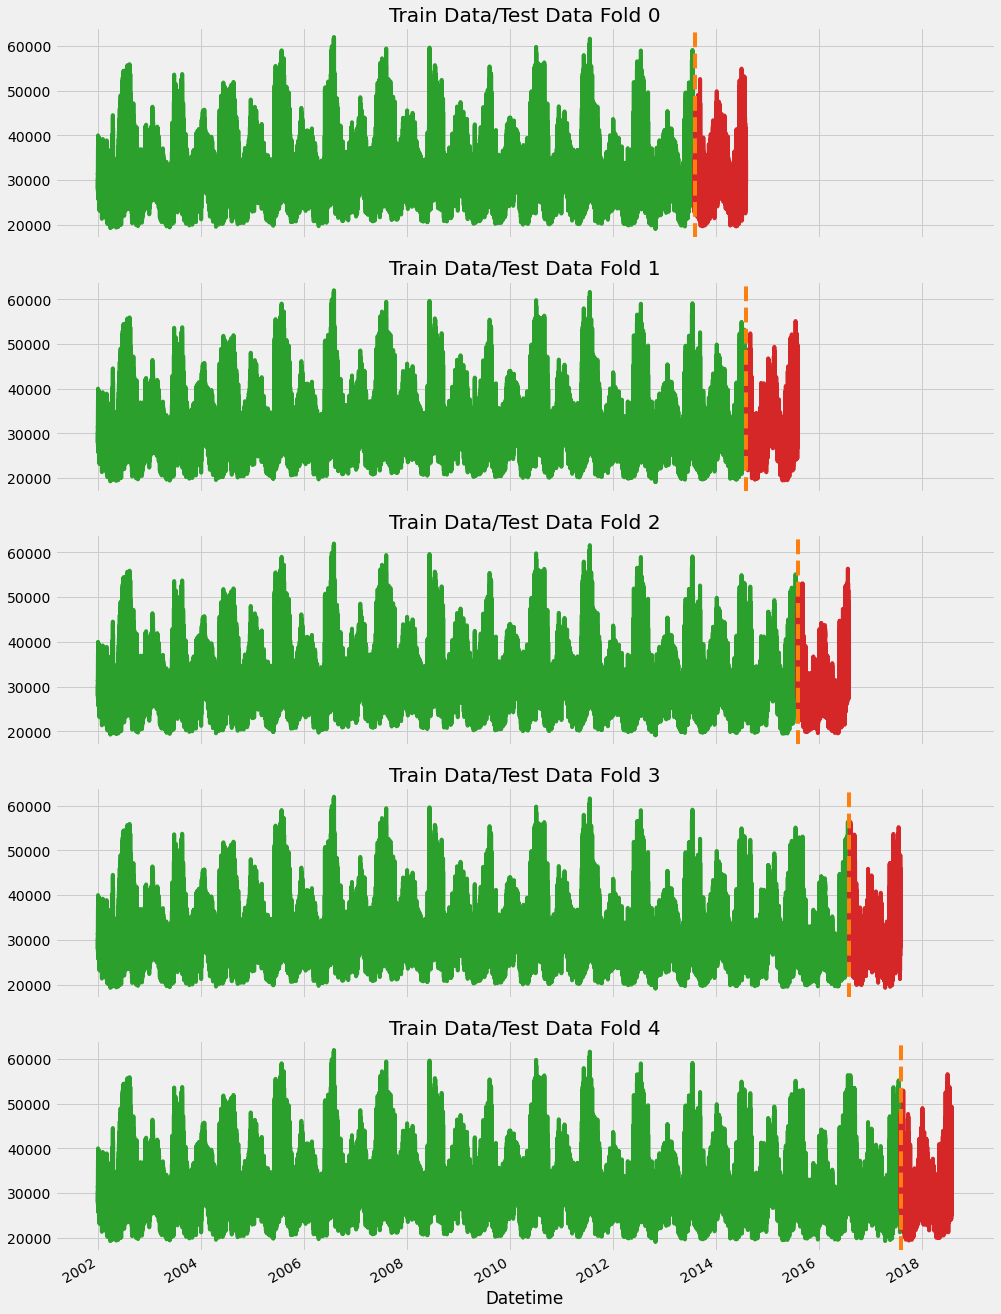

In [12]:
fig, ax = plt.subplots(5, 1, figsize=(15, 25), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    
    # extract the training and testing data
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    # lets also plot it 
    train['PJME_MW'].plot(ax=ax[fold], label='Training Data', 
                          title=f'Train Data/Test Data Fold {fold}',color=color_pal[2])
    test['PJME_MW'].plot(ax=ax[fold], label='Test Data',color=color_pal[3])
    ax[fold].axvline(test.index.min(), color=color_pal[1], ls='--')
    fold +=1
plt.show()

### Forecasting Horizon Explained

The Forecast Horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (More than two years).

Lets add the time series features.

In [13]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    
    df = df.copy()
    df["Hour"] = df.index.hour
    df["DayOfWeek"] = df.index.dayofweek
    df["Quarter"] = df.index.quarter
    df["Month"]   = df.index.month
    df["Year"]    = df.index.year
    df['DayOfYear'] = df.index.dayofyear
    df['DayOfMonth'] = df.index.day
    cols = list(df.columns)
    cols.reverse()
    df = df[cols]
    return df

df = create_features(df)
df

,DayOfMonth,DayOfYear,Year,Month,Quarter,DayOfWeek,Hour,PJME_MW
Datetime,,,,,,,,
2002-01-01 01:00:00,1,1,2002,1,1,1,1,30393.0
2002-01-01 02:00:00,1,1,2002,1,1,1,2,29265.0
2002-01-01 03:00:00,1,1,2002,1,1,1,3,28357.0
2002-01-01 04:00:00,1,1,2002,1,1,1,4,27899.0
2002-01-01 05:00:00,1,1,2002,1,1,1,5,28057.0
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,2,214,2018,8,3,3,20,44057.0
2018-08-02 21:00:00,2,214,2018,8,3,3,21,43256.0
2018-08-02 22:00:00,2,214,2018,8,3,3,22,41552.0


### Lag Features

What was the target(x) days in the past

In [14]:
def add_lags(df):
    
    target_map = df['PJME_MW'].to_dict()
    [tuple((i, target_map[i])) for i in list(target_map.keys())[:5]]
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [15]:
df = add_lags(df)
df

,DayOfMonth,DayOfYear,Year,Month,Quarter,DayOfWeek,Hour,PJME_MW,lag1,lag2,lag3
Datetime,,,,,,,,,,,
2002-01-01 01:00:00,1,1,2002,1,1,1,1,30393.0,NaN,NaN,NaN
2002-01-01 02:00:00,1,1,2002,1,1,1,2,29265.0,NaN,NaN,NaN
2002-01-01 03:00:00,1,1,2002,1,1,1,3,28357.0,NaN,NaN,NaN
2002-01-01 04:00:00,1,1,2002,1,1,1,4,27899.0,NaN,NaN,NaN
2002-01-01 05:00:00,1,1,2002,1,1,1,5,28057.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,2,214,2018,8,3,3,20,44057.0,42256.0,41485.0,38804.0
2018-08-02 21:00:00,2,214,2018,8,3,3,21,43256.0,41210.0,40249.0,38748.0
2018-08-02 22:00:00,2,214,2018,8,3,3,22,41552.0,39525.0,38698.0,37330.0


In [16]:
len(df[df['lag3'].isna()])

26240

### Training Using Cross Validation

In [17]:
df.tail()

,DayOfMonth,DayOfYear,Year,Month,Quarter,DayOfWeek,Hour,PJME_MW,lag1,lag2,lag3
Datetime,,,,,,,,,,,
2018-08-02 20:00:00,2,214,2018,8,3,3,20,44057.0,42256.0,41485.0,38804.0
2018-08-02 21:00:00,2,214,2018,8,3,3,21,43256.0,41210.0,40249.0,38748.0
2018-08-02 22:00:00,2,214,2018,8,3,3,22,41552.0,39525.0,38698.0,37330.0
2018-08-02 23:00:00,2,214,2018,8,3,3,23,38500.0,36490.0,35406.0,34552.0
2018-08-03 00:00:00,3,215,2018,8,3,4,0,35486.0,33539.0,32094.0,31695.0


In [18]:
df.columns

Index(['DayOfMonth', 'DayOfYear', 'Year', 'Month', 'Quarter', 'DayOfWeek',
       'Hour', 'PJME_MW', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [19]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [20]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)


df = df.sort_index()
fold = 0
preds = []
scores = []
for train_ind, val_ind in tss.split(df):
    train = df.iloc[train_ind]
    test = df.iloc[val_ind]
    
    train = create_features(train)
    test = create_features(test)
    
    Features = ['Hour', 'DayOfWeek', 'Quarter', 'Month', 'Year', 'DayOfYear', 'DayOfMonth',
               'lag1', 'lag2', 'lag3']
    Target   = ['PJME_MW']
    
    X_train = train[Features]
    Y_train = train[Target]
    
    X_test = test[Features]
    Y_test = test[Target]
    
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                            n_estimators = 1000, early_stopping_rounds=50,
                             objective = 'reg:linear', max_depth=3,
                             learning_rate=0.01,
                            )
    reg.fit(X_train, Y_train, 
           eval_set = [(X_train, Y_train), (X_test, Y_test)],
           verbose=100, 
           )
    y_predict = reg.predict(X_test)
    preds.append(y_predict)
    score = np.sqrt(mean_squared_error(Y_test, y_predict))
    scores.append(score)
    
    
    fold += 1
    
plt.show()
    
    

[15:26:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.15798	validation_1-rmse:11907.12157
[200]	validation_0-rmse:5744.94936	validation_1-rmse:5353.51632
[300]	validation_0-rmse:3868.56640	validation_1-rmse:3898.53908
[400]	validation_0-rmse:3430.63336	validation_1-rmse:3758.24522
[450]	validation_0-rmse:3356.42691	validation_1-rmse:3762.64793
[15:26:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.57784	validation_1-rmse:12221.41614
[200]	validation_0-rmse:5755.49678	validation_1-rmse:5659.10178
[300]	validation_0-rmse:3905.37621	validation_1-rmse:3934.55693
[4

In [21]:
print(f"Scores across folds are: {np.mean(scores):0.4f}")
print(f"Fold scores are: {scores}")

Scores across folds are: 3752.5431
Fold scores are: [3757.485267269142, 3439.3045300465965, 3473.3000876275805, 4093.7709283848812, 3998.8545666889618]


### Predicting the Energy Consumption

- Retraining on all Data
- An Empty DataFrame for Prediction Range
- Run above Data Range Through Feature Creation and Log Creation

In [22]:
# Retraining on all data
df = create_features(df)
    
Features = ['Hour', 'DayOfWeek', 'Quarter', 'Month', 'Year', 'DayOfYear', 'DayOfMonth',
           'lag1', 'lag2', 'lag3']

Target   = ['PJME_MW']

X_all = df[Features]
Y_all = df[Target]

reg = xgb.XGBRegressor(base_score=0.5,
                      booster = 'gbtree',
                       n_estimators = 500,
                       objective = 'reg:linear',
                       max_depth = 3,
                       learning_rate = 0.01,
                      )
reg.fit(X_all, Y_all, 
       eval_set = [(X_all, Y_all)],
        verbose=100, 
       ),


[15:28:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.43427
[200]	validation_0-rmse:5752.11136
[300]	validation_0-rmse:3971.36505
[400]	validation_0-rmse:3571.35729
[499]	validation_0-rmse:3456.28762


(XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, objective='reg:linear', predictor='auto',
              random_state=0, reg_alpha=0, ...),)

In [23]:
# Lets predict the model on the date range
prediction_range = (pd.date_range('2018-08-03', '2019-08-10', freq='1h'))
prediction_range_df = pd.DataFrame(index=prediction_range)
prediction_range_df['isPrediction'] = True
df['isPrediction'] = False
df_and_predict = pd.concat([df, prediction_range_df])
df_and_predict

,lag3,lag2,lag1,PJME_MW,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,isPrediction
2002-01-01 01:00:00,NaN,NaN,NaN,30393.0,1.0,1.0,1.0,1.0,2002.0,1.0,1.0,False
2002-01-01 02:00:00,NaN,NaN,NaN,29265.0,2.0,1.0,1.0,1.0,2002.0,1.0,1.0,False
2002-01-01 03:00:00,NaN,NaN,NaN,28357.0,3.0,1.0,1.0,1.0,2002.0,1.0,1.0,False
2002-01-01 04:00:00,NaN,NaN,NaN,27899.0,4.0,1.0,1.0,1.0,2002.0,1.0,1.0,False
2002-01-01 05:00:00,NaN,NaN,NaN,28057.0,5.0,1.0,1.0,1.0,2002.0,1.0,1.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-09 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-08-09 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-08-09 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2019-08-09 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [24]:
# Creating Lag and DataFrame features
df_and_predict = create_features(df_and_predict)
df_and_predict = add_lags(df_and_predict)
df_and_predict

,isPrediction,DayOfMonth,DayOfYear,Year,Month,Quarter,DayOfWeek,Hour,PJME_MW,lag1,lag2,lag3
2002-01-01 01:00:00,False,1,1,2002,1,1,1,1,30393.0,NaN,NaN,NaN
2002-01-01 02:00:00,False,1,1,2002,1,1,1,2,29265.0,NaN,NaN,NaN
2002-01-01 03:00:00,False,1,1,2002,1,1,1,3,28357.0,NaN,NaN,NaN
2002-01-01 04:00:00,False,1,1,2002,1,1,1,4,27899.0,NaN,NaN,NaN
2002-01-01 05:00:00,False,1,1,2002,1,1,1,5,28057.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-09 20:00:00,True,9,221,2019,8,3,4,20,NaN,NaN,37704.0,50436.0
2019-08-09 21:00:00,True,9,221,2019,8,3,4,21,NaN,NaN,37214.0,49664.0
2019-08-09 22:00:00,True,9,221,2019,8,3,4,22,NaN,NaN,35703.0,47839.0
2019-08-09 23:00:00,True,9,221,2019,8,3,4,23,NaN,NaN,33359.0,44735.0


In [25]:
predict_with_features = df_and_predict.query('isPrediction').copy()
predict_with_features

,isPrediction,DayOfMonth,DayOfYear,Year,Month,Quarter,DayOfWeek,Hour,PJME_MW,lag1,lag2,lag3
2018-08-03 00:00:00,True,3,215,2018,8,3,4,0,NaN,33539.0,32094.0,31695.0
2018-08-03 01:00:00,True,3,215,2018,8,3,4,1,NaN,30781.0,29503.0,29128.0
2018-08-03 02:00:00,True,3,215,2018,8,3,4,2,NaN,29015.0,27712.0,27373.0
2018-08-03 03:00:00,True,3,215,2018,8,3,4,3,NaN,27884.0,26535.0,26233.0
2018-08-03 04:00:00,True,3,215,2018,8,3,4,4,NaN,27223.0,25870.0,25643.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-09 20:00:00,True,9,221,2019,8,3,4,20,NaN,NaN,37704.0,50436.0
2019-08-09 21:00:00,True,9,221,2019,8,3,4,21,NaN,NaN,37214.0,49664.0
2019-08-09 22:00:00,True,9,221,2019,8,3,4,22,NaN,NaN,35703.0,47839.0
2019-08-09 23:00:00,True,9,221,2019,8,3,4,23,NaN,NaN,33359.0,44735.0


### Prediction Of Energy consumption

In [26]:
predict_with_features['Prediction'] = reg.predict(predict_with_features[Features])

#### Visualization

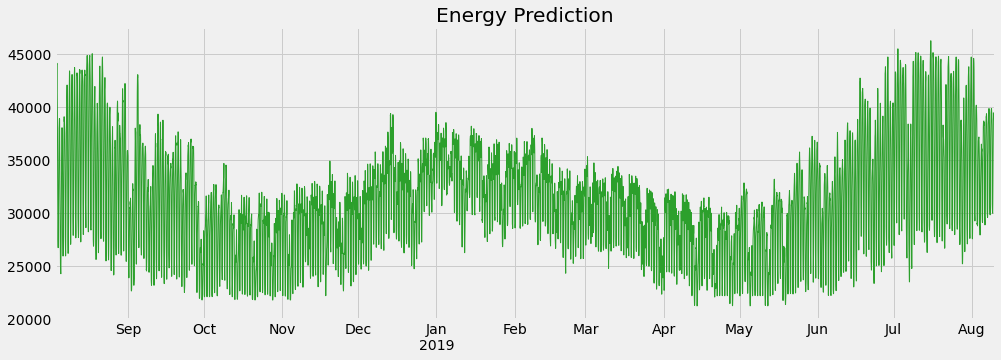

In [27]:
predict_with_features['Prediction'].plot(figsize=(15, 5), color=color_pal[2], ms=1, lw=1, 
                                        title='Energy Prediction')
plt.show()